In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats

## Data descriptions:
doi: 10.24432/C5002N
<br><br>AP (Ambient Pressure) Feature,	Continuous, (range 992.89-1033.30 milibar)	units:milibar
<br>RH	(Residual Humidity) Feature,	Continuous, (range 25.56% to 100.16%)	units:%
<br>AT	(Ambient Temperature) Feature,	Continuous,	(range 1.81°C and 37.11°C)	units: C
<br>V (Exhaust Vacuum)	Feature	Continuous (range 25.36-81.56 cm Hg)        	units: cm Hg
<br><br>PE	(Net hourly electrical output of the plant) Target,	Continuous,	(range 420.26-495.76 MW)	units:MW
 
<b><u>combined cycle power plant:</b></u>
<br>-electricity of the plant is generated by steam,gas turbines, and returned heat
<br>-the vacuum is colected from and has effect on the steam turbine
<br>-ambient variables affect gas turbine performance


## Project goal:
use environment features to predict net hourly electrical energy output of the plant (EP)

In [5]:
### Libraries for Machine Learning
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR






In [3]:
df = pd.read_csv('CombinedCyclePowerPlant.csv', sep=',')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [7]:


############################################################################################################
#
#   Base Class for the Model
#
############################################################################################################
class Model:
    def __init__(self,X,y,test_size=0.2,random_state=42,val_size=0.25,model="LinearRegression"):
        '''
        Parameters:
        X: Features
        y: Target
        test_size: Test size
        random_state: Random state
        val_size: Validation size
        model: Model to be used
        '''
        self.model_name = model
        self.models = {
            "LinearRegression": {
                "model": lambda X, y: LinearRegression(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "OLS": {
                "model":lambda X, y: sm.OLS(y, X),
                "fit": lambda X, y: self.model.fit()
            },
            "DecisionTreeRegressor": {
                "model": lambda X, y: DecisionTreeRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "RandomForestRegressor": {
                "model": lambda X, y: RandomForestRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "GradientBoostingRegressor": {
                "model": lambda X, y: GradientBoostingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "AdaBoostRegressor": {
                "model": lambda X, y: AdaBoostRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "BaggingRegressor": {
                "model": lambda X, y: BaggingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "SVR": {
                "model": lambda X, y: SVR(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
            ,
            "MLPRegressor": {
                "model": lambda X, y: MLPRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
        }
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.val_size = val_size
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=self.val_size, random_state=self.random_state)
        self.model = self.models[self.model_name]['model'](self.X_train, self.y_train)

    @staticmethod
    def get_models():
        return ["LinearRegression", "OLS","DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "AdaBoostRegressor", "BaggingRegressor", "SVR", "MLPRegressor"]

    def train(self):
        self.model=self.models[self.model_name]['fit'](self.X_train, self.y_train)
        return self.evaluate(self.X_train, self.y_train)

    def predict(self, X):
        return self.model.predict(X)
    
    def validate(self):
        return self.evaluate(self.X_val, self.y_val)
    
    def test(self):
        return self.evaluate(self.X_test, self.y_test)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        return mse, mae, r2
    
    def summary(self):
        return self.model.summary()
    
    def plotResiduals(self, X, y):
        residuals = y - self.predict(X)
        sns.scatterplot(x=self.predict(X), y=residuals)
        plt.xlabel('Predictions')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs. Predictions')
        plt.show()

    def plot_residuals(self):
        self.plotResiduals(self.X_val, self.y_val)
    
    def plot_residuals_test(self):
        self.plotResiduals(self.X_test, self.y_test)

    def plot_residuals_val(self):
        self.plotResiduals(self.X_val, self.y_val)


In [8]:
from itertools import combinations
X = df.drop(columns=['PE']) # exclude the target
y = df['PE']
cols = X.columns
for i in range(1, len(cols)+1):
    for comb in combinations(cols, i):
        X = df[list(comb)]
        model = Model(X, y,random_state=np.random.randint(0,100))
        model.train()
        mse, mae, r2=model.validate()
        print(f'Columns: {comb}, MSE: {mse}, MAE: {mae}, R2: {r2}')

Columns: ('AT',), MSE: 29.53730071994814, MAE: 4.2207591106457265, R2: 0.8990222090008894
Columns: ('V',), MSE: 70.80497156227878, MAE: 6.5694073755363345, R2: 0.7589901065617655
Columns: ('AP',), MSE: 205.9995516819468, MAE: 11.747356042199664, R2: 0.26119152036917315
Columns: ('RH',), MSE: 248.4376489355439, MAE: 13.26683444522898, R2: 0.17602258440745777
Columns: ('AT', 'V'), MSE: 26.28860219649861, MAE: 4.021829873643594, R2: 0.9104317124142038
Columns: ('AT', 'AP'), MSE: 27.322116163188873, MAE: 4.196110063886222, R2: 0.9064053592848967
Columns: ('AT', 'RH'), MSE: 21.897526945610853, MAE: 3.7263816587488203, R2: 0.9249878320265316
Columns: ('V', 'AP'), MSE: 61.43783125807313, MAE: 6.180259648856322, R2: 0.7810575860504654
Columns: ('V', 'RH'), MSE: 65.76218656401008, MAE: 6.369613845067011, R2: 0.7722233478086763
Columns: ('AP', 'RH'), MSE: 178.11000059554195, MAE: 10.980194524371866, R2: 0.385748362674712
Columns: ('AT', 'V', 'AP'), MSE: 22.853903028368787, MAE: 3.811241242210720

In [9]:
# for all combinations of columns
from itertools import combinations
X = df.drop(columns=['PE']) # exclude the target
cols = X.columns
# Store the results in  matrix
best_combinations=[]
for trial in range(100):
    results = {}
    for i in range(2, len(cols)+1):
        for comb in combinations(cols, i):
            X = df[list(comb)]
            model = Model(X, y,random_state=np.random.randint(0,100))
            model.train()
            mse, mae, r2=model.validate()
            # print(f'Columns: {comb}, MSE: {mse}, MAE: {mae}, R2: {r2}')
            results[comb] = (mse, mae, r2)
    # Find the best combination
    best_comb = min(results, key=results.get)
    # print(f'Best combination: {best_comb}, MSE: {results[best_comb][0]}, MAE: {results[best_comb][1]}, R2: {results[best_comb][2]}')
    best_combinations.append(best_comb)

Text(0.5, 1.0, 'Most common combination of Featues')

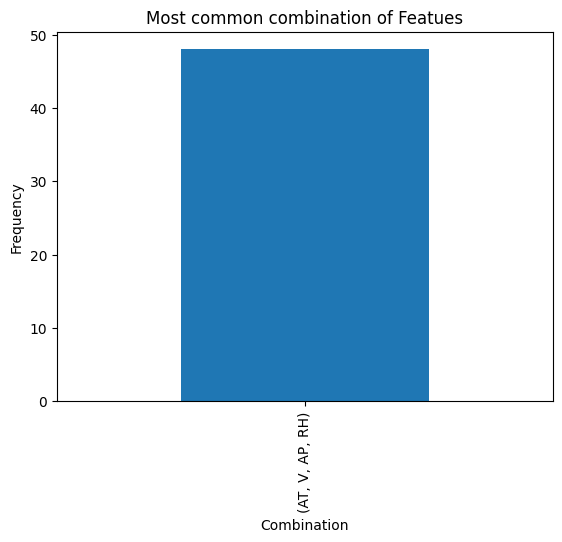

In [8]:
pd.DataFrame(best_combinations).value_counts().plot(kind='bar')
plt.xlabel('Combination')
plt.ylabel('Frequency')
plt.title('Most common combination of Featues')

In [9]:
# Best combination base line
X = df[['AT', 'V', 'AP', 'RH']]
model = Model(X, y)
model.train()
model.validate()
mse, mae, r2=model.test()
print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

MSE: 19.60479418594134, MAE: 3.545605340362234, R2: 0.9314862953524978


In [10]:
## Test the model with OLS
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:16   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
### Fit the model with 
model = Model(X, y, model="OLS")
model.train()
mse, mae, r2=model.validate()
print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

MSE: 22.030586510757747, MAE: 3.7001859213803208, R2: 0.9280216911844968


In [12]:
model = Model(X, y, model="DecisionTreeRegressor", random_state=42)
model.train()
mse, mae, r2=model.validate()
print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

MSE: 21.497786677115982, MAE: 3.1850313479623824, R2: 0.9297624542342681


In [13]:
for model_name in Model.get_models():
    model = Model(X, y, model=model_name)
    mse, mae, r2=model.train()
    print(f'Model: {model_name}, MSE: {mse}, MAE: {mae},R2: {r2}')
    mse, mae, r2=model.test()
    print(f'Model: {model_name}, MSE: {mse}, MAE: {mae}, R2: {r2}')
    mse, mae, r2=model.validate()
    print(f'Model: {model_name}, MSE: {mse}, MAE: {mae}, R2: {r2}')

Model: LinearRegression, MSE: 20.758167529254173, MAE: 3.6353005073607156,R2: 0.927849282100962
Model: LinearRegression, MSE: 19.60479418594134, MAE: 3.545605340362234, R2: 0.9314862953524978
Model: LinearRegression, MSE: 22.03058651075796, MAE: 3.7001859213803265, R2: 0.9280216911844962
Model: OLS, MSE: 20.758167529254173, MAE: 3.6353005073607205,R2: 0.927849282100962
Model: OLS, MSE: 19.60479418594166, MAE: 3.5456053403622776, R2: 0.9314862953524967
Model: OLS, MSE: 22.030586510757747, MAE: 3.7001859213803208, R2: 0.9280216911844968
Model: DecisionTreeRegressor, MSE: 0.0, MAE: 0.0,R2: 1.0
Model: DecisionTreeRegressor, MSE: 20.023415308254965, MAE: 3.1359299895506783, R2: 0.9300233223846934
Model: DecisionTreeRegressor, MSE: 20.882749164054335, MAE: 3.15162486938349, R2: 0.9317719041427693
Model: RandomForestRegressor, MSE: 1.7498879017752682, MAE: 0.9250436759581901,R2: 0.9939177835337345
Model: RandomForestRegressor, MSE: 10.749915976316611, MAE: 2.3664377742946687, R2: 0.9624318133

In [14]:
100
test=20 
val= 80*0.25=20
tran= 60

SyntaxError: cannot assign to expression (1540398380.py, line 3)

### Results:

<table>
    <tr>
        <td style="font-weight:bold">Model</td>
        <td colspan="3" style="font-weight:bold">Train</td>
         <td colspan="3" style="font-weight:bold">Test</td>
          <td colspan="3" style="font-weight:bold">Validation</td>
    </tr>
    <tr>
        <td></td>
        <td>MSE</td>
        <td>MAE</td>
        <td>R2</td>
        <td>MSE</td>
        <td>MAE</td>
        <td>R2</td>
        <td>MSE</td>
        <td>MAE</td>
        <td>R2</td>
    </tr>
    <tr>
        <td>LinearRegression</td>
        <td>20.76</td>
        <td>3.64</td>
        <td>0.93</td>
        <td>19.60</td>
        <td>3.55</td>
        <td>0.93</td>
        <td>22.03</td>
        <td>3.70</td>
        <td>0.93</td>
    </tr>
    <tr>
        <td>OLS</td>
        <td>25.49</td>
        <td>4.03</td>
        <td>0.91</td>
        <td>24.18</td>
        <td>3.94</td>
        <td>0.92</td>
        <td>26.86</td>
        <td>4.08</td>
        <td>0.91</td>
    </tr>
    <tr>
        <td style="font-weight:bold"><b>DecisionTreeRegressor<b></td>
        <td>0.00</td>
        <td>0.00</td>
        <td style="font-weight:bold"><b>1.00<b></td>
        <td>20.51</td>
        <td>3.14</td>
        <td>0.93</td>
        <td>21.05</td>
        <td>3.18</td>
        <td>0.93</td>
    </tr>
    <tr>
        <td style="font-weight:bold">RandomForestRegressor</td>
        <td>1.68</td>
        <td>0.92</td>
        <td>0.99</td>
        <td>10.73</td>
        <td>2.36</td>
        <td style="font-weight:bold">0.96</td>
        <td>12.06</td>
        <td>2.52</td>
        <td style="font-weight:bold">0.96</td>
    </tr>
    <tr>
        <td>GradientBoostingRegressor</td>
        <td>13.47</td>
        <td>2.80</td>
        <td>0.95</td>
        <td>14.25</td>
        <td>2.90</td>
        <td>0.95</td>
        <td>16.43</td>
        <td>3.09</td>
        <td>0.95</td>
    </tr>
    <tr>
        <td>AdaBoostRegressor</td>
        <td>28.29</td>
        <td>4.26</td>
        <td>0.90</td>
        <td>27.19</td>
        <td>4.15</td>
        <td>0.90</td>
        <td>32.53</td>
        <td>4.44</td>
        <td>0.89</td>
    </tr>
    <tr>
        <td>BaggingRegressor</td>
        <td>2.47</td>
        <td>1.02</td>
        <td>0.99</td>
        <td>11.79</td>
        <td>2.52</td>
        <td>0.96</td>
        <td>13.24</td>
        <td>2.63</td>
        <td>0.96</td>
    </tr>
    <tr>
        <td>SVR</td>
        <td>200.95</td>
        <td>11.90</td>
        <td>0.30</td>
        <td>200.63</td>
        <td>11.83</td>
        <td>0.30</td>
        <td>220.77</td>
        <td>12.36</td>
        <td>0.28</td>
    </tr>
    <tr>
        <td>MLPRegressor</td>
        <td>23.44</td>
        <td>3.82</td>
        <td>0.92</td>
        <td>22.22</td>
        <td>3.74</td>
        <td>0.92</td>
        <td>24.15</td>
        <td>3.85</td>
        <td>0.92</td>
    </tr> 

</table>


In [ ]:
for i in range(1,11):
    model=Model(X, y, model="RandomForestRegressor",test_size=0.2+ (0.02*i),random_state=42,val_size=0.25)
    model.train()
    model.test()
    mse, mae, r2=model.validate()
    print(f'Model: RandomForestRegressor, MSE: {mse}, MAE: {mae}, R2: {r2} for test_size: {0.2+ (0.02*i)}')